# Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

In [1]:
install_graph_nets_library = "No"  #@param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library and dependencies:")
  print("Output message from command:\n")
  !pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
else:
  print("Skipping installation of Graph Nets library")

Skipping installation of Graph Nets library


# load libraries

In [2]:
import configparser
confParser = configparser.ConfigParser()
confParser.read('config.ini')
confParser.sections()


['gnn library path', 'python libarary path', 'test data files']

In [3]:
import sys
sys.path.append(confParser['gnn library path']['gnnLibDir'])
sys.path.append(confParser['python libarary path']['pyLibDir'])
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pdb
import utility as utl
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
import os
import traceback
import imp
imp.reload(utl)
from scipy.spatial import KDTree

import functools
from typing import Any, Dict, Text,Tuple,Optional


import enum
import pickle
#from absl import logging
import numpy as np


import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

import sonnet as snt

from graph_nets import graphs
from graph_nets import modules as gn_modules
from graph_nets import utils_tf
from gnn_graphnet_model import *
from graph_nets import utils_np

from sklearn.preprocessing import StandardScaler
from scipy import stats


# utility funcs

In [114]:
class Interpolate:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index):

        self.query_index = query_index.flatten()
        self.query_xy    = cords
        self.val = val.copy()

    def kdTree(self,k):
        dd, ii = tree.query([self.query_xy], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x].flatten(),self.neigh_mat))]
        assert np.all(list(map(lambda x:np.any(x>0.0),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[x>0.0],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: x.mean(), h_list))
        query_rows = np.arange(self.query_index.shape[0])[query_index]
        self.val[query_rows] = np.c_[h_mean]
        
        
def load_test_data(test_data_file_path,test_data_file_path2nd):
    # read the csv file and return the text line list.
    test_data_row_list = pd.read_csv(test_data_file_path,sep=',')
    test_data_row_list2nd = pd.read_csv(test_data_file_path2nd,sep=',')
    print('open and load data from test_data.csv complete.')
    return test_data_row_list, test_data_row_list2nd

def train_test_split(x,y):
    xlo, xhi = x.min(), x.max()
    ylo, yhi = y.min(), y.max()
    x_copy = np.array(x.copy() - xlo)
    y_copy = np.array(y.copy() - ylo)
    
    return x_copy < 0.7 * (xhi-xlo)

    
def base_graph( 
               test_data_file_path, 
               test_data_file_path2nd,
               logtrans=False
              ):
    """
    This here loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target 	     here the array containing the nodal target data
        weight	     if needed, a weight parameter given for the (training) nodes
    """
    
    test_data, test_data2nd = load_test_data(test_data_file_path, 
                                             test_data_file_path2nd
                                            )
    #--- do interpolation for missing attributes
    interp = Interpolate(np.c_[test_data[['x','y']]],
                         np.c_[test_data['h(Gpa)']],
                         np.c_[test_data['h(Gpa)']==0.0],
                               )

    interp.kdTree(64) #--- nearest neighbors
    interp.interpolate()

    #--- update data frame
    cols = list(test_data.keys())
    cols.remove('h(Gpa)')
    test_data = pd.DataFrame(np.c_[test_data[cols],interp.val.flatten()],columns=cols+['h(Gpa)'])

    
    #--- assignment
    positions = np.c_[test_data[['x','y','perimeter','boundarySize','numNeighbors']]].tolist() 
    edges = list(map(lambda x:[x],np.array(test_data2nd['misOrientationAngle(deg)'])))
    receivers = list(test_data2nd['grain_j_index'].astype(int))
    senders = list(test_data2nd['grain_i_index'].astype(int)) 
    #--- target vector
    xp=np.arange(0,1,0.01)
    y=test_data['boundarySize'].apply(lambda x:x*xp**2+np.random.normal(size=len(xp)))
    y = np.c_[y.to_list()]

    
    target = list(map(lambda x:[x],np.array(1.0/test_data['perimeter'])))
    #list(map(lambda x:[x],np.array(test_data['h(Gpa)']))) #list(map(lambda x:list(x),y)) #
#    target =  list(map(lambda x:[x],np.array(test_data['h(Gpa)'])))
    
    train_mask = train_test_split(test_data['x'],test_data['y']) #--- change!!!!
#    train_mask = np.tile(train_mask, (100, 1)).T
    
    val_mask = test_mask = ~train_mask
    weight = list(np.ones(test_data.shape[0]))

    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },\
            train_mask, val_mask, test_mask, target, weight 

#    return {"globals": [0.0],  "nodes": nodes_data[:,1:], "edges": edges_data[:,2:],  
#            "receivers": edges_data[:,1].astype(int), "senders": edges_data[:,0].astype(int)  }, 
#            train_mask, val_mask, test_mask, target, weight 



def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
#         pdb.set_trace()
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op


def create_corr_ops(target_op, output_op, mask):
    corr_op = tfp.stats.correlation(tf.boolean_mask(target_op, mask), tf.boolean_mask(output_op.nodes, mask))
    return corr_op




# Creating graphs

In [115]:
#--- set parameters
SEED =4441666
np.random.seed(SEED)
tf.set_random_seed(SEED)
#
pure_lab='' 
data_split = None
data_split_lab=''
#
num_processing_steps_tr = 3
#--- Data / training parameters.
num_training_iterations = 10000 #000#0 #20000
learning_rate = 1e-2 #7.5e-6

#--- path for csv data files
test_data_file_path=confParser['test data files']['test_data_file_path']
test_data_file_path2nd=confParser['test data files']['test_data_file_path2nd']


#--- graph structure  
static_graph_tr, train_mask_np, val_mask_np, test_mask_np,\
target_nodes_np, weight_np = base_graph(test_data_file_path, 
                                        test_data_file_path2nd,
                                        logtrans=data_split)
print("NUM PROCESSING STEPS ", num_processing_steps_tr)
print("LEARNING RATE ", learning_rate)
print(static_graph_tr.keys())
for k in static_graph_tr.keys():
    try:
        print(k, static_graph_tr[k].shape)
    except AttributeError:
        print(k)

input_graph = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])
#print(input_graph)



open and load data from test_data.csv complete.
NUM PROCESSING STEPS  3
LEARNING RATE  0.01
dict_keys(['globals', 'nodes', 'edges', 'receivers', 'senders'])
globals
nodes
edges
receivers
senders


In [110]:
class Finder():
    '''
    return a list of files in a directory
    '''
    def __init__(self,path_ld):
        self.files = os.listdir(path_ld)

    def Get(self,file_index):
        return self.files[file_index]
    
class TestData:
    '''
    return the feature matrix
    '''
    ld_curve = {}
    
    def __init__(self,path_ld,path_gb,verbose=False):
        self.path_ld = path_ld #--- ld data
        self.path_gb = path_gb #--- grain properties
        self.verbose = verbose

    def is_included(self,xlo,xhi):
        '''
        return bool: timeseries includes the range (xlo,xhi) 
        '''
        return self.data[:,0].min() <= xlo and self.data[:,0].max() >=  xhi   
            
    def Parse(self):
        if self.verbose:
            print('parsing %s'%(self.path_ld))
        self.data    = np.loadtxt( self.path_ld ) #--- load curve
        self.grains  = pd.read_csv(self.path_gb ,sep=',')
        
    def Interp(self,bins):
        '''
        interpolate on the structured grid bins
        '''
        self.xsum = np.interp(bins, self.data[:,0], self.data[:,1], left=None, right=None, period=None)
        self.edges = bins
            
    def GetGrainIndex(self):
        '''
        return grain index and id 
        '''
        GetGrainID = lambda x:x[x.find('ID_')+3:x.find('_LoadID')]
        GrainID = GetGrainID(self.path_ld)
        filtr = self.grains['#grainID']==float(GrainID)
        assert np.any(filtr), 'grainID %s not exist!'%GrainID
        return self.grains[filtr].index[0]
    
    @staticmethod
    def Append(GrainIndex,xsum):
        '''
        append stress timeseries
        '''
        TestData.ld_curve.setdefault(GrainIndex,[]).append(xsum.copy()) #--- repetative
        
    @staticmethod
    def FeatureMat():
        '''
        return feature matrix
        '''
        keys=list(TestData.ld_curve.keys())
        keys.sort()
        for key,count in zip(keys,range(len(keys))):
            ydata=TestData.ld_curve[key][0]
            if count == 0:
                x_feature = ydata.copy()
                continue
            x_feature=np.c_[ydata,x_feature]
        return x_feature.T

## target data

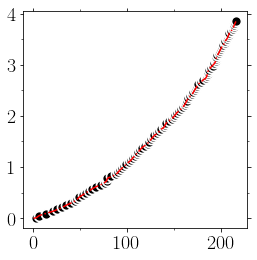

<AxesSubplot:>

In [68]:
symbols=utl.Symbols()

finder=Finder(confParser['test data files']['load_depth_path'])
finder.Get(0)

#--- parse load curve
test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],finder.Get(0)),
                     path_gb=confParser['test data files']['test_data_file_path'],
                    )

test_data.Parse()
ax=utl.PltErr(test_data.data[:,0],test_data.data[:,1],
#                xlim=(0,20),ylim=(0,0.2),
               attrs=symbols.GetAttrs(count=0,fmt='.'),
              Plot=False,
               )
test_data.Interp(bins=np.arange(test_data.data[:,0].min(),test_data.data.max(),1.0))
utl.PltErr(test_data.edges,test_data.xsum,
#                xlim=(0,20),ylim=(0,0.2),
               attrs={'fmt':'-.r'},
                ax=ax
#               attrs=symbols.GetAttrs(fmt='-.r'),
            
                )

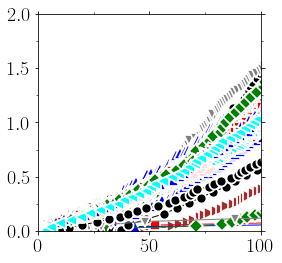

In [45]:
ax  = utl.PltErr(None,None,Plot=False)
for fp,count in zip(finder.files,range(len(finder.files))): #--- loop over indented grains
    test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],fp),
                     path_gb=confParser['test data files']['test_data_file_path'],
                     verbose=False,
                    )
    test_data.Parse()
    if not test_data.is_included(0.0,100.0): #--- ld curve includes this range
        continue
    test_data.Interp(bins=np.arange(0.0,100.0,1.0)) #--- interpolate
    try:
        GrainIndex = test_data.GetGrainIndex()
    except:
        continue
    #--- plot
    utl.PltErr(test_data.data[:,0],test_data.data[:,1],
                attrs=symbols.GetAttrs(count=count%7),
               ax=ax,Plot=False,
               xlim=(0,100), ylim=(0,2),
              
              )
    TestData.Append(GrainIndex,test_data.xsum) #--- assemble feature matrix

## Visualize 
### euclidean space

In [21]:
plt.plot(np.c_[static_graph_tr['nodes']][train_mask_np][:,0],
         np.c_[static_graph_tr['nodes']][train_mask_np][:,1],
         '.',
        markersize=10
        )
for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
    x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
    y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
    plt.plot(x,y,'-')

IndexError: index 1 is out of bounds for axis 1 with size 1

In [161]:
# for op in output_ops:
#     corr_op_tr.append( create_corr_ops(target_nodes, op, train_mask))


# Train

In [116]:
train_mask = tf.constant(train_mask_np, dtype=tf.bool)
test_mask  = tf.constant(test_mask_np , dtype=tf.bool)
val_mask   = tf.constant(val_mask_np  , dtype=tf.bool)

target_nodes = tf.constant(target_nodes_np)
weight = tf.constant(weight_np)
weight = None ##NOTE comment out if weights wanted 


# Create the model.
node_output_size = len(target_nodes_np[0])
model = EncodeProcessDecode(node_output_size=node_output_size)
#print(model.summary())

#--- training base graph
output_ops, latent_ops = model(input_graph, num_processing_steps_tr) #[-1]
# Training loss.
loss_op_tr = []
loss_op_va = []
loss_op_ts = []
corr_op_tr = []
corr_op_va = []
corr_op_ts = []

for op in output_ops:
    loss_op_tr.append( create_loss_ops(target_nodes, op, train_mask,weight))
    loss_op_va.append( create_loss_ops(target_nodes, op,   val_mask,weight))
    loss_op_ts.append( create_loss_ops(target_nodes, op,  test_mask,weight))
    corr_op_tr.append( create_corr_ops(target_nodes, op, train_mask))
    corr_op_va.append( create_corr_ops(target_nodes, op,   val_mask))
    corr_op_ts.append( create_corr_ops(target_nodes, op,  test_mask))

# Training loss across processing steps.
loss_op_tr_sum = sum(loss_op_tr) / num_processing_steps_tr


# Optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr_sum)


training_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
correlat_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
counter = 0


# This cell resets the Tensorflow session, but keeps the same computational
# graph.
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print(snt.format_variables(model.variables))

best_corr = np.zeros((num_processing_steps_tr,3))
best_val_loss = np.inf
best_corr_loss = 0.0
best_val_loss_all = np.inf*np.ones(num_processing_steps_tr)
best_corr_loss_all = np.zeros(num_processing_steps_tr)
last_improved = 0
early_stopping_crit = 500


measure_val_by_loss= True
print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

# #--- training loop
for iteration in range(num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "outputs": output_ops,
        "latents": latent_ops,
        "corr": corr_op_tr

    })
    

    test_values = sess.run({
        "loss_val":  loss_op_va,
        "loss_test": loss_op_ts,
            "corr_val": corr_op_va,
            "corr_test": corr_op_ts
    })
    training_history[counter, 0:num_processing_steps_tr] = train_values['loss']
    training_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = test_values['loss_val']
    training_history[counter, 2*num_processing_steps_tr:] = test_values['loss_test']

    correlat_history[counter, 0:num_processing_steps_tr] = np.median(train_values['corr'])
    correlat_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = np.median(test_values['corr_val'])
    correlat_history[counter, 2*num_processing_steps_tr:] = np.median(test_values['corr_test'])



    if (iteration+1) %10==0:
        print("# {:05d}, training {:.4f}, validation {:.4f}, test {:.4f}".format(iteration+1,training_history[counter,num_processing_steps_tr-1], training_history[counter,2*num_processing_steps_tr-1],training_history[counter,-1]  ))

        for i in range(num_processing_steps_tr):
            if measure_val_by_loss:
                cond =  (training_history[counter,num_processing_steps_tr+i] < best_val_loss_all[i])
                cond_best = (training_history[counter,num_processing_steps_tr+i] < best_val_loss)
            else:
                cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
                cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
            if cond:
                step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
#                 pdb.set_trace()
                best_corr[i,0] = stats.pearsonr( step_output[train_mask_np].flatten(),  np.array(target_nodes_np)[train_mask_np].flatten() )[0]
                best_corr[i,1] = stats.pearsonr( step_output[val_mask_np].flatten(),   np.array(target_nodes_np)[val_mask_np].flatten() )[0]
                best_corr[i,2] = stats.pearsonr( step_output[test_mask_np].flatten(),   np.array(target_nodes_np)[test_mask_np].flatten() )[0]
                #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))
                best_val_loss_all[i] = training_history[counter,num_processing_steps_tr+i]
                best_corr_loss_all[i] = correlat_history[counter,num_processing_steps_tr+i]
                if cond_best:
                    best_output = np.copy(step_output)
                    best_latent = sess.run(latent_ops[i])
                    #print(best_latent.shape)
                    best_val_loss = training_history[counter,num_processing_steps_tr+i]
                    best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
                    last_improved = counter
    counter+=1 
    if counter > last_improved + early_stopping_crit:
        print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
        break


f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

training_history = training_history[:counter]
correlat_history = correlat_history[:counter]
for i in range(num_processing_steps_tr):
    print("    {} steps:  best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
    latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
#     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)



# np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
# np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
# np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
# np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)


Variable                                                               Shape  Type     Collections                            Device
EncodeProcessDecode_2/graph_independent/node_model/node_output/b       1      float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode_2/graph_independent/node_model/node_output/w       8x1    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/layer_norm/beta     8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/layer_norm/gamma    8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/mlp/linear_0/b      8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/mlp/linear_0/w      1x8    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/mlp/li

# 00100, training 0.0129, validation 0.0226, test 0.0226
# 00110, training 0.0127, validation 0.0215, test 0.0215
# 00120, training 0.0123, validation 0.0206, test 0.0206
# 00130, training 0.0121, validation 0.0200, test 0.0200
# 00140, training 0.0120, validation 0.0196, test 0.0196
# 00150, training 0.0118, validation 0.0193, test 0.0193
# 00160, training 0.0116, validation 0.0186, test 0.0186
# 00170, training 0.0115, validation 0.0184, test 0.0184
# 00180, training 0.0114, validation 0.0181, test 0.0181
# 00190, training 0.0113, validation 0.0178, test 0.0178
# 00200, training 0.0112, validation 0.0175, test 0.0175
# 00210, training 0.0111, validation 0.0171, test 0.0171
# 00220, training 0.0109, validation 0.0166, test 0.0166
# 00230, training 0.0107, validation 0.0161, test 0.0161
# 00240, training 0.0106, validation 0.0156, test 0.0156
# 00250, training 0.0104, validation 0.0151, test 0.0151
# 00260, training 0.0103, validation 0.0146, test 0.0146
# 00270, training 0.0101, valid

## mse

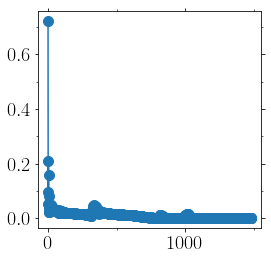

<AxesSubplot:>

In [117]:
utl.PltErr(range(training_history.shape[0]),training_history[:,-1])

In [ ]:
# with sess.as_default():
#     print(output_ops[0].receivers.eval().shape)

## predictions

mkdir: png: File exists


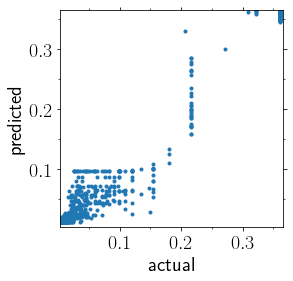

<AxesSubplot:xlabel='actual', ylabel='predicted'>

In [118]:
!mkdir png
#ax=utl.PltErr(target_nodes_np,target_nodes_np,attrs={'fmt':'-r'},Plot=False)
filtr = [train_mask_np,test_mask_np][0]
xmin=np.min([target_nodes_np,best_output])
xmax=np.max([target_nodes_np,best_output])
utl.PltErr(target_nodes_np, best_output,
           attrs={'fmt':'.'},
            xlim=(xmin,xmax),
           ylim=(xmin,xmax),
           title = 'png/hardness.png',
           xstr='actual',
           ystr='predicted',
#           ax=ax,
          )

test set


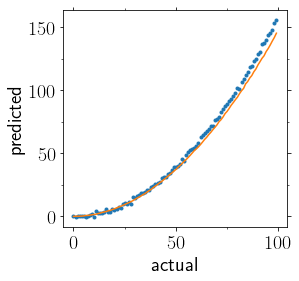

<AxesSubplot:xlabel='actual', ylabel='predicted'>

In [249]:
grain_indx=1
if train_mask_np[grain_indx]:
    print('training set')
else:
    print('test set')

ax=utl.PltErr(range(len(target_nodes_np[grain_indx])),
           target_nodes_np[grain_indx], 
           attrs={'fmt':'.'},
            Plot=False
             )

utl.PltErr(range(len(target_nodes_np[grain_indx])),
           best_output[grain_indx],
           attrs={'fmt':'-'},
#            xlim=(xmin,xmax),
#           ylim=(xmin,xmax),
#           title = 'png/hardness.png',
           xstr='actual',
           ystr='predicted',
           ax=ax,
          )